# EPSRC: AI Skills Through Music 🤖🎹

© 2025, [Dr. Huw Cheston](https://huwcheston.github.io), Queen Mary University of London

## Useful Links

- Documentation for the [`numpy` Python package](https://numpy.org/doc/)
- Documentation for [`librosa`](https://librosa.org/)
- Documentation for [`pytorch`](https://docs.pytorch.org/docs/stable/index.html)
- `TinySOL` [dataset documentation](https://zenodo.org/records/3685331)
- An example of [K-Means clustering with `scikit-learn`](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py)
- An example of [K-Nearest Neighbours classification with `scikit-learn`](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py)

## 2: Learning Paradigms 🧠

In the previous notebook, we saw how **AI can't see, read, or hear in the same way you or I do.** Instead, **anything you show an AI** (a photo, a paragraph, or an audio clip) must first be converted into a **numbers, vectors, and matrices**, which we call **representations**.

So, you might now be wondering: ***how does AI use these representations to do complicated things, like generate text or understand audio?***

The answer is that AI can learn in **many different ways**, depending on the type of data available and what we want it to do. We can call these different ways of teaching AI our **learning paradigms**. In this notebook, we'll explore two of the main ways in which we can "teach" an AI model:

1. **Unsupervised Learning**: like learning by finding patterns on your own, without specific instructions.
2. **Supervised Learning**: like learning from a teacher, who shows you examples and corrects you when you make a mistake.

In [ ]:
!pip install mirdata -q -q

import IPython.display as ipd
import math
import mirdata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import seaborn as sns
import torch
from joblib import Parallel, delayed
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

np.set_printoptions(suppress=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.0/429.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 5.9 MB/s eta 0:00:00

## Musical Instrument Classification 🪘

In this notebook, we are going to explore different ways in which we can **teach an AI model** to recognise **musical instruments** from **audio recordings**. Our model could be useful if a musician wanted to *search a collection of recordings* to find those by the instrument that they play.

But first, before we try teaching a machine to do this task, let's try it ourselves. Watch the video below. *How many instruments can you identify?* What qualities are you listening out for?

In [ ]:
ipd.HTML('''
<iframe width="560" height="315"
src="https://www.youtube.com/embed/tb0gHAzpQPE"
referrerpolicy="strict-origin-when-cross-origin"
</iframe>
''')

## Data 🔢

To train our models, we're going to need some data. Ideally, our dataset should have the following:

- A **large number** of audio recordings;
- made on **different musical instruments;**
- with a variety of different **acoustic qualities** (playing styles, volume levels, etc.)
- available with a **license** that allows for training machine learning models with non-commercial applications

> **Important:** we always need to check the **license** of any dataset we use to train a machine learning model. Some disallow commercial use, meaning we couldn't sell our model or use it in any way which makes us money.

### TinySOL 🌞

One dataset that fits our needs is the `TinySOL` dataset. This contains 2,913 musical notes recorded from 14 different musical instruments. The instruments are:

1. Tuba 📯
2. French Horn 📯
3. Trombone 🎺
4. Trumpet 🎺
5. Accordion 🎹
6. Double bass 🎻
7. Violin 🎻
8. Viola 🎻
9. Cello 🎻
10. Bassoon 🪈
11. Clarinet 🪈
12. Flute 🪈
13. Oboe 🪈
14. Saxophone 🎷

TinySOL is released under a **CC-BY-4.0 license**. This means that it can be reused **by anyone and for any purpose** (including machine learning), on the condition that the creator is appropriately credited.

> **Good to know:** for more information on TinySOL and how it was created, [check out this website.](https://zenodo.org/records/3685331)

### MIRData 🎹

In order to work with TinySOL in Python, we're going to use the [`mirdata`](https://github.com/mir-dataset-loaders/mirdata) library. This will allow us to download the dataset and load its audio files **directly in Python**. It will also allow us to *validate* the dataset, to make sure that we have all the correct files and that nothing has gone wrong when downloading.

Note that TinySOL is quite large (**1 gigabyte**). Depending on the internet connection, *it may take a while to download*, so please be patient.

> **Important**: if you encounter any HTML errors, please **retry the download** by **rerunning the cell**.

In [ ]:
tinysol = mirdata.initialize('tinysol')
tinysol.download()

979MB [17:31, 977kB/s]                            
312kB [00:02, 127kB/s]                           
488kB [00:03, 126kB/s]                           


In [ ]:
tinysol.validate()

100%|██████████| 2913/2913 [00:09<00:00, 292.80it/s]


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

Great! We've downloaded TinySOL and confirmed that the dataset is valid and complete. Let's take a listen to one of the audio files:

In [ ]:
track = tinysol.choice_track()
# Identical output to `librosa.load(filename=...)`
y, sr = track.audio
ipd.Audio(y, rate=sr)

Note that TinySOL was recorded with a *sample rate* of 44,100 Hz.

> **Important**: if you're not sure what we mean by **sample rate**, check out the previous notebook on **Data Representations**.

### Dataset Exploration 📊

Let's start by taking a little look at some of the properties of this dataset.

We can start by taking a look at **how many recordings there are** in TinySOL.

In [ ]:
print(len(list(tinysol.load_tracks().values())))

OK, we have **2,913 recordings in total** to work with in `TinySOL`.

#### Most Common Instrument 🎹

Next, let's look at **the number of recordings by each musical instrument**. We'll create a **bar chart** in order to show this.

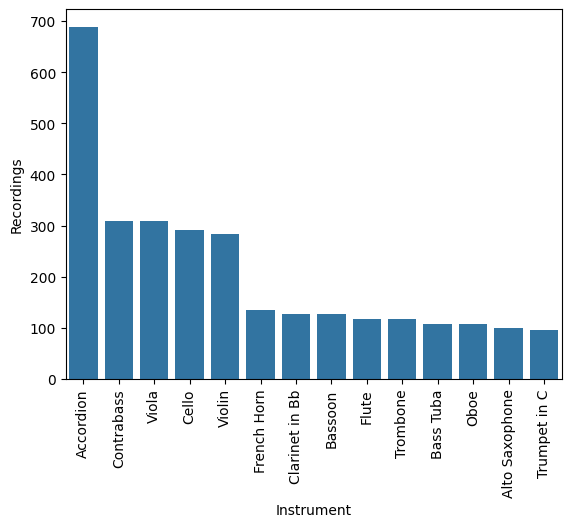

In [ ]:
instrs = [rec.instrument_full for rec in tinysol.load_tracks().values()]
res = pd.Series(instrs).value_counts().reset_index(drop=False)
sns.barplot(data=res, x="index", y="count")
plt.xticks(rotation=90)
plt.gca().set(xlabel="Instrument", ylabel="Recordings")
plt.show()

Great, from looking at this plot, we can see that **the vast majority of recordings** are on the Accordion. If you're not familiar with this instrument, this is what it looks like:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/Paris_-_Accordion_Player_-_0956.jpg/1200px-Paris_-_Accordion_Player_-_0956.jpg" width="400px"/>

Look at the graph again. You can see that the next most popular instrument after the Accordion in the **Contrabass** (sometimes also called the **Double Bass**).

However, the number of Contrabass recordings is **half that** of Accordion recordings. We might call a dataset like this **unbalanced**: the most popular class appears **much more often** than every other class.

#### Instrument Groups 🎻

We can also group the instruments in `TinySOL` by some common characteristics. For instance, both **Cello** and **Violin** have strings and are played with a **bow**.

These groups can be called **families**. We have four **families** in `TinySOL`:
1. **Strings**: played by scraping wire strings with a bow, like a **Violin**
2. **Keyboards**: played by **pressing down on keys**, like a piano
3. **Winds**: played by blowing over an opening, like a **Flute**
4. **Brass**: played by blowing into a metal (or **brass!**) *mouthpiece*, like the **Trumpet**.

Luckily, `TinySOL` already classifies recordings by different instrument families. Let's take a look at the **number of recordings** by each family:

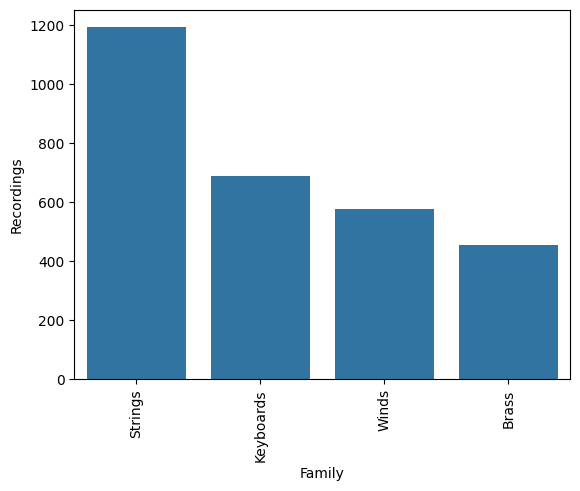

In [ ]:
fams = [rec.family for rec in tinysol.load_tracks().values()]

# Note that this code is unchanged from the previous cell
res = pd.Series(fams).value_counts().reset_index(drop=False)
sns.barplot(data=res, x="index", y="count")
plt.xticks(rotation=90)
plt.gca().set(xlabel="Family", ylabel="Recordings")
plt.show()

Great: we can see now that the vast majority of recordings are by instruments from the **string** family (e.g., **Violin**, **Viola**), whereas **brass** recordings (e.g., **Trumpet**, **Trombone**) are much less common in our dataset.

#### Why Perform Exploratory Analyses? 🤔

It's always a good idea to start any data science or machine learning project by exploring the **properties, features, and distribution of classes** in your dataset, just like we have done here. This can help you *discover important factors or trends* that you might need to control for in your analysis or modelling.

> **Think about:** what other exploratory analyses could we perform for this dataset? What might we learn by doing this?

## Feature Engineering 🔢

We already know that AI models don't work with audio recordings directly. Instead, we can extract low-level statistics from an audio signal and use these to train the AI instead. We called these statistics **features**.

> **Important**: if you want a refresher on how we extract **features** from an audio signal, check out the **Data Representations** notebook.

We'll now see how we can use these features to train our model to **identify instruments** in the recordings from TinySOL.

### Spectrogram 🎨

Before we can extract these features, we need to represent our audio with a **spectrogram**. As a reminder, a spectrogram uses *short-time Fourier transforms* (STFTs) to express the time, amplitude, and frequency of an audio signal as a two dimensional matrix.

> **Important**: if you're not sure what a spectrogram or STFT is, take another look at the Data Representations notebook.

Let's look at a spectrogram extracted from our audio signal:

In [ ]:
X_stft = np.abs(librosa.stft(y, win_length=512, hop_length=256))
spect = librosa.amplitude_to_db(X_stft)

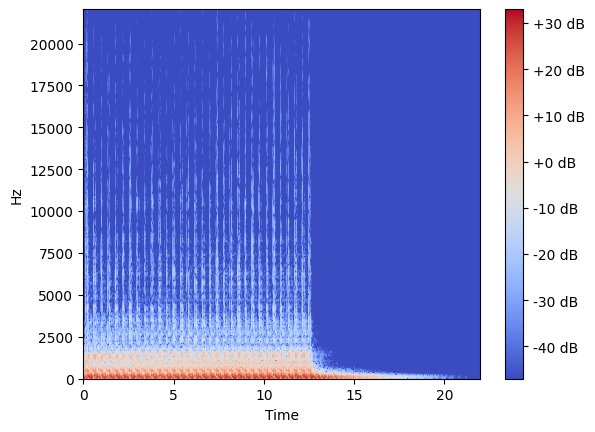

In [ ]:
librosa.display.specshow(spect, sr=sr, x_axis="time", y_axis="linear")
plt.colorbar(format="%+2.0f dB")
plt.show()

### Feature Extraction 🏗️

In the **Data Representations** notebook, we explored two types of **feature**:
1. **spectral centroid**: the average frequency of every **column** in the spectrogram
2. **spectral bandwidth**: the standard deviation of every **column** in the spectrogram

Alongside these, we can also consider several additional features:

3. **spectral flatness**: measures how "noisy" a sound is: high flatness means the sound is noiser, low flatness means its more like a single note
4. **spectral rolloff**: the frequency below which most of the signal’s energy is concentrated (usually 85%); it helps show whether a sound is "bright" (more high frequencies) or "dark" (mostly low frequencies).
5. **root-mean-square**: measures the average loudness of a sound over time: a whisper has a low RMS, while a shout has a high RMS
6. **zero-crossing rate**: the fraction of samples in a frame that cross 0, usually higher for noisy or percussive sounds

For exact mathematical definitions of these features, refer to the [`librosa` documentation](https://librosa.org/doc/main/feature.html)

#### Defining a Function 💻

We're going to define a Python **function** that does the following:

1. Converts an audio waveform into a magnitude spectrogram
2. Extracts the **six features** described above from every frame of the spectrogram
3. Stacks these features into a matrix with shape `(N_frames, N_features)`. In other words, every **row** is a frame, and every **column** is a feature

We'll use a frame size of 512 samples and a hop of 256. This means that we'll compute the FFT from samples `0:512`, then `256:768`, then `512:1024`, and so on until we run out of audio.


In [ ]:
def feature_extractor(waveform: np.ndarray, sr: float) -> np.ndarray:
    """
    Extracts temporal features from an audio signal.

    Returns a 2D array, where each row is a frame and each column is a feature
    """
    # Compute the spectrogram
    X_stft = librosa.stft(waveform, win_length=512, hop_length=256)
    spect = np.abs(librosa.amplitude_to_db(np.abs(X_stft)))

    # Extract every feature
    spectral_centroids = librosa.feature.spectral_centroid(S=spect,)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(S=spect,)
    spectral_flatness = librosa.feature.spectral_flatness(S=spect,)
    spectral_rolloff = librosa.feature.spectral_rolloff(S=spect,)
    rmse = librosa.feature.rms(S=spect,)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(waveform, frame_length=512, hop_length=256)

    # Stack the features to the shape (N_frames, N_features)
    return np.vstack([
        spectral_centroids,
        spectral_bandwidth,
        spectral_flatness,
        spectral_rolloff,
        rmse,
        zero_crossing_rate,
    ]).T


extracted = feature_extractor(y, sr)


Let's check the shape of the feature matrix:

In [ ]:
print(extracted.shape)

(1893, 6)


Great! We can see the number of frames in order file as the first number in above. For every frame, we've extracted 6 **spectral features**.


#### Frames or Recordings? 🖼

While we could train our model on data extracted from every **frame**, there might be some problems with this:

- Given that each frame lasts a very short amount of time (around 0.01 second!), we might expect successive frames to contain **very similar information**;
- Some frames might not contain audio: for example, if the musician stopped playing **before the recording ended**. These frames could confuse a model.

Because of these reasons, we can instead **average** every feature for a single recording. Recall the equation for the mean of the values in a vector $x$:

$$
\text{mean}(x) = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

In other words, imagine you had a table with $x$ columns and $i$ rows. You could convert this into a single row by taking the **average value in every column**.

This is exactly what we're going to do now, using `numpy`:

In [ ]:
extracted_vector = np.mean(extracted, axis=0)
print(extracted_vector.shape)

(6,)


Notice how we set the `axis=0` parameter above. This means that we **averaged over** the first axis in the matrix (i.e., frames or rows). Compare the shape of `extracted` and `extracted_vector` to see what we mean.

> **Think about:** what would happen if we set `axis=1`? What shape would we get? Try it out!

We now have a **feature vector**: a one-dimensional vector with shape `(N_features,)`. Let's print this out:

In [ ]:
print(extracted_vector.round(3))

[5965.331 2997.62     0.823 9541.712    0.956    0.02 ]


### Data Pipeline 🧰

We can now proceed to define our complete **data pipeline**. This needs to do the following:

1. Load an audio file from `TinySOL`
2. Extract the six spectral features from every frame to create a matrix with shape `(N_frames, N_features)`
3. Average every feature over each frame to create a vector of shape `(N_features,)`
4. Stack this vector for every recording to create a matrix with shape `(N_recordings, N_features)`

Run the cell below to extract features from all the recordings in `tinysol`. Note that this may take a while, *so please be patient!*

> **Note:** we use the `joblib` library to process multiple recordings **in parallel**, rather than waiting for one recording to finish before starting on the next. This *significantly* reduces the wait time.

In [ ]:
def process(track: tuple) -> np.ndarray:
    """
    Extract average features for a single recording.
    """
    # Extract the features for every frame: shape (N_frames, N_features)
    extracted = feature_extractor(track.audio[0], track.audio[1])
    # Average the features over all frames to create a vector: shape (N_features,)
    extracted_vector = np.mean(extracted, axis=0)
    return extracted_vector


# Load up all the recordings from tinysol
all_recordings = tinysol.load_tracks()
# Initialise an empty list to store all the feature vectors
all_features = []

# Iterate over all the recordings: we use `Joblib` to parallelise the process
#  setting verbose=... increases how often we'll log our progress to the console
with Parallel(n_jobs=-1, verbose=5) as parallel:
    all_features = parallel(delayed(process)(track) for track in all_recordings.values())

# Stack all of the vectors into a matrix with shape (N_recordings, N_features)
feature_matrix = np.array(all_features)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 478 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 802 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1372 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1642 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1948 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 2668 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2913 out of 2913 | elapsed:  7.8min finished


Great! We can confirm that our pipeline worked correctly by looking at the *shape of the feature matrix*:

In [ ]:
print(feature_matrix.shape)

(2913, 6)


This shows we have 2913 recordings, the same number as in `TinySOL`. For each of these recordings, we have 6 features.

#### Visualising Feature Distributions 📃

Let's start taking a closer look at some of our features.

For now, we'll just visualise the spectral centroid and zero-crossing rate of each recording using **histograms**. These plots show the distribution of values by binning data into discrete groups. We can also add to these histograms with **kernel density estimates (KDE)**.

> **Good to know:** think of the KDE as a bit like a *smoothed histogram*. It transforms the distribution of values for a feature into a continuous sequence.

We'll use the `seaborn` library to create these plots.

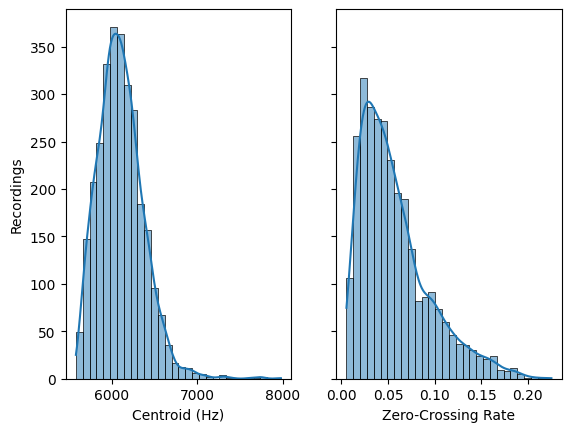

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)

sns.histplot(feature_matrix[:, 0], kde=True, ax=ax[0], bins=30)
sns.histplot(feature_matrix[:, 5], kde=True, ax=ax[1], bins=30)

ax[0].set(xlabel="Centroid (Hz)", ylabel="Recordings")
ax[1].set(xlabel="Zero-Crossing Rate", ylabel="")

plt.show()

We can notice a few things about these plots:
- Both distributions are **right-tailed** (positive skew). This means that the majority of values are on the *left* of the plot, but that it has a long *right* tail (extreme positive values).
- The tail for the Zero-Crossing Rate variable is wider than that of Spectral Centroid

What else do you notice about these plots?

<img src="https://substackcdn.com/image/fetch/$s_!OKCR!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F7f061ca2-1507-4394-8c31-834b94a75777_2048x566.png" width="600px"/>



### Pre-Processing ✨

Something else we can see from looking at the distributions is that the minimum and maximum values of the spectral centroid variable is **much larger** than that obtained for the zero-crossing rate.

This is because the spectral centroid will range between 0 Hz and the highest frequency that can be measured in a recording. Meanwhile, the zero-crossing rate is measured as a fraction of total samples in the frame, and so will be between 0 and 1.

> **Did you know?** The highest measurable frequency in an audio recording is called the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency). It is equivalent to half the sampling rate (i.e., 22,050 Hz, for the recordings in TinySOL).

If we were to train our model directly on the raw data we've extracted, **it might take a very long time to learn anything**. This is because the **difference in ranges** might prevent the model from learning **connections between features**.

To prevent this from happening, machine learning scientists usually **normalise** or **standardise** their features.

#### Normalisation 🔢

Normalisation means to adjust features measured on diferent scales to a *common scale*. This new scale is **identical** for every feature.

There are many different types of normalisation, including:

*Min-max normalisation*: this involves rescaling the values for a feature to between 0 and 1. We assign 0 to the smallest value, and 1 to the largest. So, to transform the feature $x$ to the normalised feature $\hat{x}$:

$$
\hat{x} = \dfrac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}
$$

*Mean centering*: this involves subtracting the average value for a feature from every value we have obtained. This **centres** the feature to have a mean of 0. We use the normal mean formula, as before:

$$
\hat{x} = x - \frac{1}{n} \sum_{i=1}^{n} x_i
$$

*Log normalisation*: this involves applying a **logarithmic transformation** to the feature. This reduces the impact of very large values and spreads out smaller values, which can help when we have extreme outliers.

$$
\hat{x} = \text{log}(x)
$$

Let's apply these types of transformation to our spectral centroid, and show how the distribution changes.

In [ ]:
# Get just the values for the spectral centroid feature
spectral_centroids = feature_matrix[:, 0]

# Min-Max scaling
min_centroid = spectral_centroids.min()
max_centroid = spectral_centroids.max()
centroid_minmax = (spectral_centroids - min_centroid) / (max_centroid - min_centroid)

# Mean scaling
centroid_mean = spectral_centroids - np.mean(spectral_centroids)

# Log scaling (we'll use a base 2 transformation)
centroid_log = np.log2(spectral_centroids)

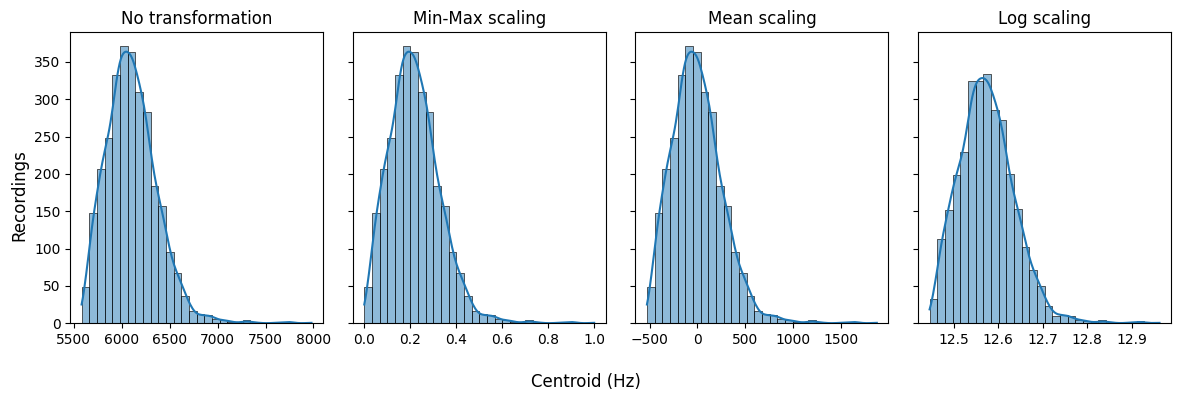

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=True, figsize=(12, 4))

sns.histplot(spectral_centroids, kde=True, ax=ax[0], bins=30)
sns.histplot(centroid_minmax, kde=True, ax=ax[1], bins=30)
sns.histplot(centroid_mean, kde=True, ax=ax[2], bins=30)
sns.histplot(centroid_log, kde=True, ax=ax[3], bins=30)

ax[0].set(title="No transformation", ylabel="")
ax[1].set(title="Min-Max scaling", ylabel="")
ax[2].set(title="Mean scaling", ylabel="")
ax[3].set(title="Log scaling", ylabel="")

fig.supylabel("Recordings")
fig.supxlabel("Centroid (Hz)")
plt.tight_layout()

plt.show()

Notice how each transformation effects the scale of the x-axis differently, but doesn't change the shape of the distribution all that much.

#### Standardisation 🔤

While there are many different types of **normalisation**, **standardisation** typically refers to a single process (sometimes called **Z-score standardisation** or simply **Z-scoring**).

This process transforms a feature to have a **mean of 0** and a **standard deviation of 1**.

The formula is very simple. First, recall the formulae for calculating the mean $\bar{x}$ and standard deviation $s$ of a feature $x$:

$$
\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i \quad , \\
s = \sqrt{\frac{\sum_{i=1}^{n}{(x_i-\bar{x})^2}}{n-1}} \quad ,
$$

where $x_i$ is the value for feature $x$ at index $i$ and $n$ is the total number of values in $x$.

Then, we can calculate Z-scores as:

$$
Z_{x_i} = \dfrac{x_i - \bar{x}}{s} \quad .
$$

Let's apply **Z-scoring** to our data:

In [ ]:
centroids_z = (spectral_centroids - np.mean(spectral_centroids)) / np.std(spectral_centroids)

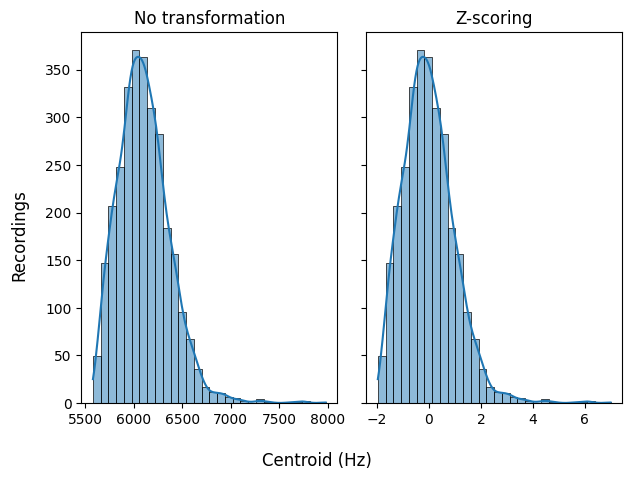

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)
sns.histplot(spectral_centroids, kde=True, ax=ax[0], bins=30)
sns.histplot(centroids_z, kde=True, ax=ax[1], bins=30)

ax[0].set(title="No transformation", ylabel="")
ax[1].set(title="Z-scoring", ylabel="")

fig.supylabel("Recordings")
fig.supxlabel("Centroid (Hz)")
plt.tight_layout()
plt.show()

Notice how applying **standardisation** has centred the data to have a **mean of 0** and scaled it to have a **standard deviation of 1**. We can check this:

In [ ]:
print(round(np.mean(centroids_z)))
print(round(np.std(centroids_z)))

0
1


#### Normalisation vs. Standardisation 🤔

One of the most common questions asked by students learning feature engineering for machine learning is whether they should normalise or standardise their data. The answer is: ***it depends!***

Normalisation is usually appropriate when using machine learning algorithms that rely on distances between data points. This includes **k-Nearest Neighbours (kNN)**, which we'll learn more about later. This is to prevent features with larger scales from dominating the distance calculation.

On the other hand, standardisation is appropriate in cases where features vary widely in magnitude and variance. Some machine learning algorithms, including **Support Vector Machines (SVM)**, expect **data to be standardised**.

Machine learning scientists will often experiment with different methods of transforming their feature set before applying their model.

#### Pre-Processing `TinySOL` Data 🔢

For now, we'll use **min-max normalisation**.Let's write a function to apply it to every feature in our feature set. We'll then use `np.apply_along_axis` to apply this function separately to every column in our feature matrix.

> **Try it out:** once you've run this notebook once, try modifying the cell below to use **Z-scoring** instead. How does this change the cells after this one?

In [ ]:
def minmax_norm(feature: np.ndarray) -> np.ndarray:
    """
    Normalises a feature to have min(F) = 0, max(F) = 1
    """
    min_ = feature.min()
    max_ = feature.max()
    return (feature - min_) / (max_ - min_)


# If you want to try z-scoring instead, use this function
# def zscore(feature: np.ndarray) -> np.ndarray:
    # return (feature - np.mean(feature)) / np.std(feature)


norm_feature_matrix = np.apply_along_axis(minmax_norm, 0, feature_matrix)

Let's check that our normalised matrix has the same shape as the original input:

In [ ]:
print(f"Input: {feature_matrix.shape}")
print(f"Output: {norm_feature_matrix.shape}")

Input: (2913, 6)
Output: (2913, 6)


Let's also check that we've normalised each feature correctly. We can do this by printing out the **minimum** and **maximum** value in each column.

In [ ]:
for col in norm_feature_matrix.T:
    print(col.shape, round(col.min(), 3), round(col.max(), 3))

(2913,) 0.0 1.0
(2913,) 0.0 1.0
(2913,) 0.0 1.0
(2913,) 0.0 1.0
(2913,) 0.0 1.0
(2913,) 0.0 1.0


OK, we've now done the following:

1. **Downloaded and validated** our dataset of musical instrument recordings;
2. **Extracted our set of 6 features** from every recording;
3. **Preprocessed and normalised** our features.

Now we're ready to start training some models!

## Unsupervised Learning 🔲

The first type of machine learning paradigm we are going to explore is called **unsupervised learning**.

Unsupervised learning is a type of machine learning where the computer looks for patterns in data without being told what the "right answer" is. Instead of labels, it tries to group or organise the data on its own.

Imagine you have a big box of mixed-up LEGO pieces. You don't know what kind of sets they belong to. Unsupervised learning is like **sorting the pieces into groups by colour, shape, or size,** without anyone telling you which piece goes where.

<img src="https://brickbin.co.uk/cdn/shop/files/WhatsAppImage2023-11-20at15.37.53_1_934x700.jpg?v=1703013842" width="400px"/>



Examples of **unsupervised learning in action** include:
- Identifying patterns in weather data, like seasons or extreme events
- Finding common themes in large sets of text, like news articles or reviews
- Detecting unusual bank transactions that might be fraud

<img src="https://www.bombaysoftwares.com/_next/image?url=https%3A%2F%2Fbs-cms-media-prod.s3.ap-south-1.amazonaws.com%2FUnsupervised_Learning_951a02cb59.jpg&w=1200&q=75" width="600px"/>

In this notebook, we're going to use unsupervised learning to **group together recordings in `TinySOL` made by the same musical instrument**. For example, we want a recording by the **Violin** to be grouped with **other Violin recordings**, and not with **Trumpet** recordings.

### k-Means Clustering 🇰

Clustering models are a type of unsupervised learning that aim to group data into distinct **clusters**.

Consider a village where there are groups of houses built together. When you first look at the village, you just see a load of houses. However, you could mentally start placing points in the **center of each group of houses**, and name each point as a **unique identifier**. You would then be able to refer to each group of houses **by a unique name** to describe them.

This is essentially what k-means clustering does with data. Mathematically, k-means starts by guessing a few center points (called ***centroids*** - but don't confuse this with our **spectral centroid** feature!!). Each data point is then assigned to the nearest center. The centers are moved to the average position of the points in their group, and this process repeats until the centers stop changing - forming clear, natural clusters.

<img src="https://media.datacamp.com/legacy/v1725630538/image_9c867e067e.png" width="600px"/>

#### Simple k-Means with Two Dimensions 💕

Let's try applying k-Means clustering to our data. To do this, we'll use the implementation in the `sklearn` Python package.

> **Take note:** for now, *we're only going to train the model using the spectral centroid and zero-crossing rate features*. This will make visualising the model's predictions a bit easier. Later on, we'll use the full feature space.


In [ ]:
model = KMeans(n_clusters=3, random_state=42, n_init="auto")
# Fit the model just to the spectral centroid and zero crossing rate
X = norm_feature_matrix[:, [0, 5]]
model.fit(X)

KMeans(n_clusters=3, random_state=42)

You may have noticed that we provided a variety of parameters to the model. At the moment, the only one we need to think about is `n_clusters`. This is the **number of clusters** the model should try and find.

Initially, we set this to 3. This is because TinySOL contains both brass 🎺, woodwind 🪈, and stringed 🎻 instruments, so this should prove enough to do some useful clustering.

> *Once you've tried with 3 clusters, why not try re-running the code with a greater number of clusters?*

We can access the cluster assigned to each recording by using the `labels_` attribute of the model.

In [ ]:
labels = model.labels_
print(labels.shape)

(2913,)


We can see that we have one label for every recording in `TinySOL`.

#### Plotting Features vs Decision Boundaries 📉

Now that we've fitted our model, we can plot the **decision boundaries**. These are the regions  that show how the model separates different recordings into different clusters, depending on the values of each feature.

We'll plot the decision boundaries for our two features: the zero-crossing rate, and the spectral centroid.

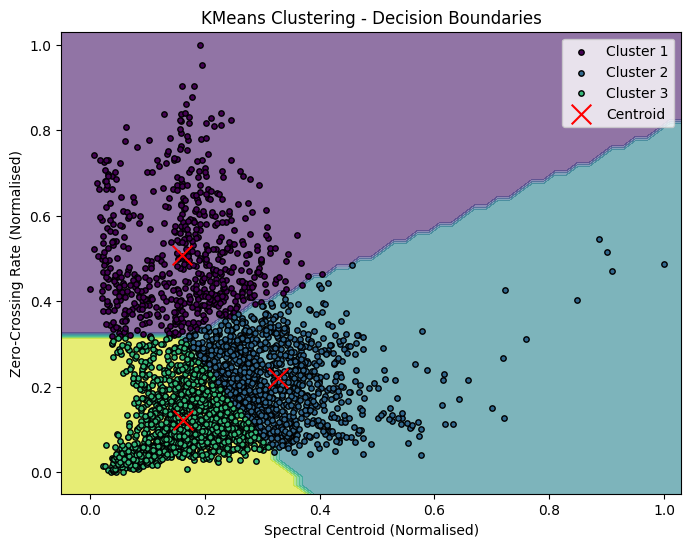

In [ ]:
# Create grid of values to predict
#  Don't worry about understanding every line of code here
#  The general idea is that we need to predict the cluster at
#  every possible value of X (spectral centroid) and Y (ZCR)
#  So, we create a matrix of values uniformly sampled between ~0 and ~1
#  for every feature, and then predict at every value in this matrix
x_min, x_max = X[:, 0].min() - 0.05, X[:, 0].max() + 0.05
y_min, y_max = X[:, 1].min() - 0.05, X[:, 1].max() + 0.05
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, 0.02),
    np.arange(y_min, y_max, 0.02)
)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create the figure and set some aesthetics
plt.figure(figsize=(8, 6))
plt.xlabel('Spectral Centroid (Normalised)')
plt.ylabel('Zero-Crossing Rate (Normalised)')
plt.title('KMeans Clustering - Decision Boundaries')

# Plot the decision boundaries
plt.contourf(xx, yy, Z, alpha=0.6, cmap='viridis')

# Plot each cluster
#  We use a for loop so we can label them separately
for cluster_id in range(model.n_clusters):
    plt.scatter(
        X[model.labels_ == cluster_id, 0],
        X[model.labels_ == cluster_id, 1],
        color=plt.cm.viridis(cluster_id / model.n_clusters),
        s=15,
        edgecolor='k',
        label=f'Cluster {cluster_id + 1}'
    )

# Plot cluster centers
centroids_2d = model.cluster_centers_
plt.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    c='red',
    s=200,
    marker='x',
    label="Centroid"
)

plt.legend()
plt.show()

In the plot we just created:

- Individual data points show individual recordings
- The x-axis shows the normalised spectral centroid
- The y-axis shows the normalised zero-crossing rate
- The shaded regions on the plot show the **decision boundaries** learned by the model for different clusters.
- The crosses show the **centroid** of each cluster


**What can we learn from this plot?** Here are a few ideas:

1. Recordings in cluster 1 have both a low spectral centroid and zero-crossing rate
2. Several recordings in cluster 2 have a much larger spectral centroid, but still a low zero-crossing rate
3. Vice-versa, several recordings in cluster 3  have a low spectral centroid, but a much higher zero-crossing rate.

> **Think about:** what else can we learn from this plot?

### K-Means with Higher-Dimensional Feature Space 👪

However, there is **still quite a lot of overlap in the center of the plot** between both clusters, which suggests that these two features alone may not be adequate to fully separate the recordings.

We can try fitting the model again, but this time with our full set of 6 features. Note that this will make it a *bit harder to visualise the decision boundaries* (it's hard to plot in six dimensions at the same time!). But we can still look at the number of recordings by each instrument within every cluster.

To start with, let's train the model using the complete feature space. We'll use the same number of clusters as before (`n_clusters=3`)

In [ ]:
model_full = KMeans(n_clusters=3, random_state=42, n_init="auto")
# Fit the model to the full feature space
model_full.fit(norm_feature_matrix)

KMeans(n_clusters=3, random_state=42)

Great. Now, let's take a look at the *number of recordings by each instrument* that are assigned to each cluster.

We'll start by iterating through every track in TinySOL and getting the instrument, as well as the cluster assigned by the model.

In [ ]:
track_iter = list(all_recordings.values())
features_all = model_full.labels_
res = []

# Iterate through each track, with a counter
for idx, track in enumerate(track_iter):
    # Get the predicted cluster
    track_predicted_cluster = features_all[idx]
    # Get the instrument
    track_instr = track.instrument_full
    # Append everything to a list
    res.append(dict(instr=track_instr, cluster=track_predicted_cluster))

To make plotting this data a bit easier, we can use the `pandas` library. Let's convert the data into a table (which `pandas` calls a `DataFrame`).

In [ ]:
df = pd.DataFrame(res)

Now, we can do the following:
- Group by each instrument
- Calculate the proportion of recordings by that instrument that fall into each cluster: 1, 2, or 3

In [ ]:
proportion = (
    # Group by the instrument and select the "cluster" column in each group
    df.groupby("instr")["cluster"]
    # Count the number of appearances of each cluster in each group and normalize to sum to 1
    .value_counts(normalize=True)
    # These lines just change some aesthetic qualities of the table:
    #  Convert the index (instr) to a normal column
    .reset_index(drop=False)
    #  Sort the values first by their cluster, and then by their instrument
    .sort_values(by=["cluster", "instr"])
    #  Reset the index again, so it counts up from 0
    .reset_index(drop=True)
    #  Rename the columns
    .rename(columns={"instr": "Instrument", "cluster": "Cluster", "proportion": "Proportion"})
)

Let's plot the results!

/tmp/ipython-input-296191084.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90)


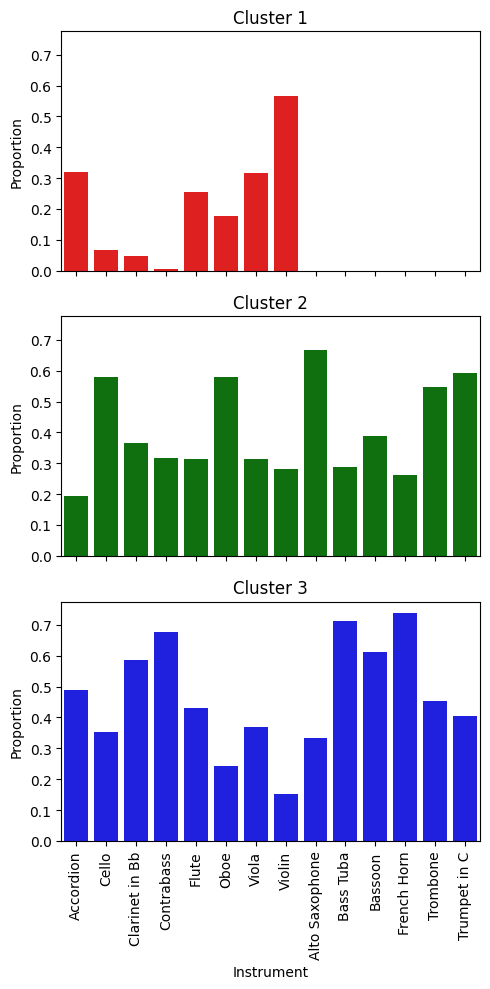

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(5, 10))
colors = ["red", "green", "blue"]
for (idx, grp), a_ in zip(proportion.groupby("Cluster"), ax.flatten()):
    sns.barplot(ax=a_, data=grp, x="Instrument", y="Proportion", color=colors[idx])
    a_.set_title(f"Cluster {idx+1}")
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()


### Interpreting Clusters 🤔

Take a look at the proportion of recordings by each instrument assigned to each cluster. **What do you notice?**

Here are some possible interpretations:

- Cluster 1 is dominated by recordings featuring stringed instruments 🎻 like the violin and viola
- Cluster 2 contains a majority of recordings by several brass 🎺 and wind 🪈 instruments, including the **trumpet**, **trombone**, **saxophone**, and **oboe**
- Cluster 3 contains **lower pitched** brass 🎺 and wind 🪈 instruments, including the **french horn**, **bassoon**, and **bass tuba**

Note, however, that most instruments contain recordings in **every cluster**. This suggests that our full feature space may not be adequate to characterise each instrument. *Why do you think this might be?*

#### Fitbit's "Sleep Animals" 🐻

> In unsupervised learning, how we interpret the clusters found by our model is **often up to us**!

A good example of this comes from **Fitbit**, a company that makes wearable smart devices like watches. They engineered ***over 1,000 features*** from sleep data provided by their users. These included features like the probability a wearer would wake up in the first hour of sleep, the mean length of their sleep cycle, and how consistent they were at waking up at the same time each night.

Then, they trained an unsupervised learning model on this data, using **6 clusters**. They assigned these clusters names based on **animals**. For instance, somebody whose "sleep animal" is a tortoise might take a long time to fall asleep, but spends longer in bed. Somebody whose animal is a giraffe, meanwhile, may experience shorter yet deeper sleep periods and earlier waking times.

> For more information, check out [Google's research blog on sleep animals.](https://blog.google/products/fitbit/fitbit-sleep-profile-animals/)

<img src="https://storage.googleapis.com/gweb-uniblog-publish-prod/images/sleep_profile_animals_hero2.width-1300.jpg" width="600px"/>



## Supervised Learning 🎓

In the previous section, we saw how unsupervised learning models tend to shine in cases where our **data is unlabelled**. But what about when we ***do*** have labels for our data? After all, we know which instrument made which recording in TinySOL!

The next type of machine learning paradigm we are going to explore is called **supervised learning**. Supervised learning is a type of machine learning where the computer learns from data that **does include the "right answers"** - in other words, each example comes with a label that tells the model what the correct output should be. The goal is for the model to learn the relationship between the input data and these labels, so it can make **accurate predictions on new, unseen data.**

For example:
- Predicting tomorrow's temperature based on past weather data
- Classifying news articles by topic (e.g. politics, sports, entertainment)
- Detecting fraudulent transactions by learning from examples of both normal and fraudulent activity

<img src="https://images.prismic.io/superpupertest/f3517801-371b-4be8-95f0-f18b3b7804f2_How-does-supervised-learning-work.webp?auto=compress,format&dpr=3" width="600px"/>

In our case, we're going to use supervised learning to train a model to **recognise which musical instrument** produced each recording in TinySOL.

### Data Splitting ➗

Before we can start with supervised learning, we need to **split our data**.  How best to split a dataset depends on many qualities, including how it was made and the number of data points within it. For now, we're just going to split our dataset into two separate parts:
- The **training set** consists of the data points we'll use to train the model;
- The **test set** consists of the data points we'll use to evaluate how well it performs. You may also see the test set called the **held-out data**, as it is **held out** from the model and not seen during training.

We need both splits of the dataset to truly understand our model: without the training split, we can't learn anything, and without the test split, we can't evaluate what we've learned.

> **Did you know?** Sometimes we may use **two separate datasets** as our training and test data. This is especially useful when **real data is hard to come by**: we can generate a large training set artificially (for instance, by using another AI model), and then evaluate performance on real-world data.

We can use `sklearn` again to split our data into training and test sets. First, let's assemble our feature set and instrument labels:

In [ ]:
X = norm_feature_matrix
y = np.array([track.instrument_full for track in track_iter])
print(X.shape, y.shape)

(2913, 6) (2913,)


Now, we'll perform the split. We end up with two `X` and two `y` variables, corresponding to the training and test data, respectively.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    test_size=0.2,
    random_state=0
)
print(f"Training feature size: {X_train.shape}")
print(f"Training label size: {y_train.shape}")
print(f"Test feature size: {X_test.shape}")
print(f"Test label size: {y_test.shape}")

Training feature size: (2330, 6)
Training label size: (2330,)
Test feature size: (583, 6)
Test label size: (583,)


Note that we used a 4:1 split, where 80% of the data ends up in the training set and 20% in the test set (see the values of `train_size=` and `test_size=`).

> **Good to know:** A 4:1 train-test split is very common in machine learning. Other common splits include 9:1 and 8:1:1 (when two separate test sets are used). However, the best split ultimately depends on the **amount of data available**. With more data, you can usually increase the number of training items used for every test item, as the total size of the test set will still remain large enough for adequate evaluation.

Let's take a look at the number of recordings by each instrument in our splits. We'll express this as a proportion of the total number of recordings in both splits

In [ ]:
names, vals = np.unique_counts(y_train)
print({str(k): float(v / sum(vals))* 100 for k, v in zip(names, vals)})

names, vals = np.unique_counts(y_test)
print({str(k): float(v / sum(vals)) * 100 for k, v in zip(names, vals)})

{'Accordion': 22.489270386266096, 'Alto Saxophone': 3.347639484978541, 'Bass Tuba': 3.9055793991416308, 'Bassoon': 4.291845493562231, 'Cello': 10.042918454935622, 'Clarinet in Bb': 4.291845493562231, 'Contrabass': 11.158798283261802, 'Flute': 3.9484978540772535, 'French Horn': 4.592274678111588, 'Oboe': 3.9055793991416308, 'Trombone': 3.9055793991416308, 'Trumpet in C': 3.4763948497854082, 'Viola': 10.557939914163091, 'Violin': 10.085836909871244}
{'Accordion': 28.30188679245283, 'Alto Saxophone': 3.6020583190394513, 'Bass Tuba': 2.9159519725557463, 'Bassoon': 4.459691252144083, 'Cello': 9.777015437392796, 'Clarinet in Bb': 4.459691252144083, 'Contrabass': 8.404802744425385, 'Flute': 4.459691252144083, 'French Horn': 4.631217838765009, 'Oboe': 2.7444253859348198, 'Trombone': 4.459691252144083, 'Trumpet in C': 2.5728987993138936, 'Viola': 10.806174957118353, 'Violin': 8.404802744425385}


#### Stratified Splitting ➗

That's interesting: 28% of the recordings in our test data feature the **Accordion**, but only 22% of those in the training data feature this instrument. If our dataset was **very unbalanced**, this could be a problem.

> For example, imagine we were building a model to predict whether a patient has a certain disease, but **95%** of the training data are healthy patients and only **5%** have the disease. Without careful handling, the model might just predict “healthy” for everyone, since it sees **so few examples of the disease.**

To accomodate this, we may want to **stratify** our data splits. This will keep the number of recordings per class approximately equal across both splits:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    test_size=0.2,
    random_state=42,
    stratify=y
)
names, vals = np.unique_counts(y_train)
print({str(k): float(v / sum(vals))* 100 for k, v in zip(names, vals)})

names, vals = np.unique_counts(y_test)
print({str(k): float(v / sum(vals)) * 100 for k, v in zip(names, vals)})

{'Accordion': 23.6480686695279, 'Alto Saxophone': 3.3905579399141628, 'Bass Tuba': 3.6909871244635193, 'Bassoon': 4.334763948497854, 'Cello': 10.0, 'Clarinet in Bb': 4.334763948497854, 'Contrabass': 10.600858369098711, 'Flute': 4.034334763948498, 'French Horn': 4.592274678111588, 'Oboe': 3.6909871244635193, 'Trombone': 4.034334763948498, 'Trumpet in C': 3.304721030042918, 'Viola': 10.600858369098711, 'Violin': 9.742489270386265}
{'Accordion': 23.67066895368782, 'Alto Saxophone': 3.430531732418525, 'Bass Tuba': 3.7735849056603774, 'Bassoon': 4.288164665523156, 'Cello': 9.948542024013722, 'Clarinet in Bb': 4.288164665523156, 'Contrabass': 10.634648370497427, 'Flute': 4.1166380789022305, 'French Horn': 4.631217838765009, 'Oboe': 3.6020583190394513, 'Trombone': 3.9451114922813035, 'Trumpet in C': 3.2590051457975986, 'Viola': 10.634648370497427, 'Violin': 9.777015437392796}


Much better: after stratification, we can see that the proportion of recordings by each instrument is **roughly the same** across both training and test data splits.

#### Data Leakage 🚰

One of the most common mistakes made by students when training machine learning models is **data leakage**. This is when data used to train the model is accidentally used to evaluate it, as well.

> Imagine if you were studying for a maths exam, and somehow the exam questions were included in your study guide. You might score perfectly, but it wouldn't reflect your true understanding of maths - you just memorised the answers in advance.

Data leakage works the same way in machine learning. Luckily, `sklearn` handles data splitting in such a way that prevents leakage. However, we can check our dataset to ensure that no feature vector in the training set also appears in the test set:

In [ ]:
for row in X_train:
    assert row not in X_test, f"Found {row} in test data!"

The `for` loop written above will test each row of the training data to make sure that it doesn't appear in the test data.

> **Try it out:** replace `for row in X_train` with `for row in X_test` in the code above to see it break!

#### Alternative Data Splitting Methods ➗

Splitting into separate training and test data is perhaps the simplest way of splitting a dataset. There are many alternatives, including:

- $k$-fold **cross validation**: rather than obtaining only one training and test dataset, we obtain $k$ training and test datasets. We typically set the value of $k$ such that each item in the dataset appears in at least one test split. To get the final performance of our model, we train on every training dataset and predict the corresponding test data, then average the performance over $k$. This means that, if our model performs very well (or very badly) on one test dataset, this won't effect the results overall.
- **train-validation-test**: this involves splitting our held-out data again into two separate splits, called the **validation** and **test** data. During training, we periodically check our performance on the validation data: once we've finished training, we evaluate the model for the final time on the test data. This is especially common when training **deep learning** models, where we may want to use the performance on the **validation** data to tell us when to stop training.

### Supervised Learning with k-Nearest Neighbours 🇰

One of the simplest and most intuitive supervised learning models is k-Nearest Neighbours (kNN).

> **Important**: don't confuse this with **k-Means Clustering** from the previous section: they are **different models**.

Imagine you move to a new city and want to find restaurants you'll like. Instead of trying to understand every cuisine in town, you ask about the restaurants your closest friends enjoy. If most of your friends love a particular place, you're likely to enjoy it too. Similarly, k-NN makes predictions based on the "nearest" examples in the data - looking at the labels of similar instances to decide the label of a new one.

Mathematically, k-NN uses the feature vector assigned to each data point. When predicting this point's label, it computes the **distance** between this point and all points in the training set. Then, it selects the $k$ closest points from the training data (hence, k-nearest neighbours!). The predicted label is typically the majority label among these neighbours.

<img src="https://trendspider.com/learning-center/wp-content/uploads/2024/08/K-Nearest-Neighbors-KNN.png" width="600px"/>




#### Train the Model 🚆

Again, we'll use `sklearn` to train the k-NN model.

The syntax looks largely the same as the unsupervised learning model. The difference is that we have to pass two values into the `.fit` function: one for our features, and another for our labels.

> **Important:** note how we only pass the `_train` data into `.fit`. We'll use a separate `.predict` function with our `_test` data later on.

In [ ]:
supervised_model = KNeighborsClassifier(n_neighbors=5,)
supervised_model.fit(X_train, y_train)

KNeighborsClassifier()

#### Evaluate the Model 🧪

Let's take a look at how well our model performs on the test data. In this case, we can simply consider how **accurate** it is. The process looks a bit like this:
- For every recording in the test data, we predict the instrument
- We assign a score of 1 for that recording if we got it right, and 0 if we got it wrong
- Finally, we average all of our scores to compute the overall accuracy.

> **Good to know:** there are many other metrics we can use to evaluate a classification model, including **top-k accuracy**, **precision**, and **recall**. We'll take a look at some of these in the following notebook, **Evaluation and Interpretation**.

In [ ]:
# Predict labels for the test data
y_pred = supervised_model.predict(X_test)
# Compute the accuracy
acc = accuracy_score(y_test, y_pred)
print(acc * 100)

68.61063464837049


#### Evaluate Against a Baseline 📊


Great! We can see that our model is ***68% accurate*** when predicting the instrument in a recording.

When we train a machine learning model, it's important that we evaluate it with relation to at least one **baseline**. A baseline could be *another model*, or a simpler method that does not use machine learning. For now, we'll consider the following **two baselines**:

1. Predicting **a random instrument** for each recording in the test data;
2. Predicting the **most common instrument** for each recording.

Let's look at **Baseline 1** first. This will allow us to compare our model to **chance performance**:

In [ ]:
def choose(seed: int) -> int:
    """
    Sets a random state, then makes a random choice
    """
    np.random.seed(seed)
    return np.random.choice(y)

y_rand = [choose(state) for state in range(len(y_pred))]
acc = accuracy_score(y_test, y_rand)
print(acc * 100)

10.120068610634648


OK: so, randomly predicting the instrument means that we're only correct 11% of the time. This means that our machine learning model is **over six times better than chance**.

We can take a look at **Baseline 2** now. For each recording, we'll simply predict that it is by the **Accordion** 🎹, the most common instrument in TinySol.

In [ ]:
# Create an array of "Accordion" predictions
#  one for every track in the test dataset.
y_acc = ["Accordion" for _ in range(len(y_pred))]
# Compute the accuracy
acc = accuracy_score(y_test, y_acc)
print(acc * 100)

23.67066895368782


Great: if we *only predict the most common class*, we'll be correct 23% of the time. So, despite being very simple, **our model is still nearly three times better** than this baseline.

> **Important**: there are many different ways to **evaluate** a supervised learning model, accuracy being just one example. In the next notebook, we'll look at other possible evaluation metrics.

### Introducing Neural Networks 🧠

We've just seen how a very simple supervised learning classifier can achieve impressive performance when identifying instruments from audio recordings. But, when we think about machine learning in the real world, most models are not this simple! Since the late 2010s, **neural networks** have become the *defacto* choice for many (but not all) supervised learning tasks.

> **Did you know?** Even though you may have only heard of them relatively recently, the theoretical principles underpinning neural networks have actually been known for a long time. However, the **computational resources required** to train these models have only recently become available.

These models are inspired by the way the **human brain works**. They consist of layers of neurons, where each neuron takes in numbers, does a little calculation, and passes the result to the next layer. By adjusting the connections between neurons during training, the network learns to recognize patterns in data - like which sounds belong to which instrument - and can make predictions on new, unseen examples.

<img src="https://clevertap.com/wp-content/uploads/2019/04/Neural_Network_Brain_Mimic.jpeg" width="600px"/>

We're now going to build a simple neural network to **identify the musical instruments** in TinySOL. Our network will have a single **linear layer**, followed by a **softmax function** and **cross-entropy loss**. We'll optimise the parameters of our model using **stochastic gradient descent**.

> **Don't worry** if you haven't come across these terms before. We'll explain each one in detail with worked examples.

We'll initially build the network from scratch in `numpy`, and then we'll implement it again using `pytorch`, a common deep learning library.

#### Linear Layer 📈

One of the foundational building blocks of a neural network is a **linear layer** (sometimes also called a **fully connected** or **dense** layer).

The linear layer takes in a feature vector, multiplies it by a **weight matrix**, and adds a **bias vector**. Essentially, this results in a weighted **sum** of the input features. This allows the network to **combine and transform input features** in ways that help it learn patterns in the data.

Mathematically, a linear layer looks a little like:

$$
y = Wx + B
$$

where $W$ is our weight matrix, $x$ is our feature vector, and $B$ is our bias term.

The shape of the weight matrix is `(in_features, out_features)`, and the shape of the bias term is `(out_features,)`. The shape of $x$ is, of course, `(in_features,)`

During training, we **update** the values within $W$ and $B$ so as to **minimize the probability** of identifying the incorrect class. This process is called **optimisation**.

> **Did you know?** Machine learning models that use large neural networks with many layers are sometimes called **deep learning** models. As our model only has a single layer, we can call it a **shallow learning** model.

#### Classification Head 🤯

A typical neural network might contain several linear layers. However, if we want to use this network as a **classifier**, we will typically always have a linear layer as the *last layer* in th emodel. We can call this layer the ***classification head***. The classification head is special because the number of output features is set to the **number of classes we have to predict** in our dataset.

> Remember that, for our instrument classifier, this is 14.

The output of the classification head consists of a vector of continuous values that we call **logits**. These are **unbounded** and can take any value, from `[-inf, +inf`].

We have **one logit** for each class. The important thing to know about logits is that they are the **predicted probability** of an input being that class, dependent on the parameters learned by the model. This means that we can take the class with the **largest logit** as the one the model predicts for an input

#### Softmax Layer and Cross-Entropy Loss 🌼

When we train our model, we usually attempt to minimize some numerical value called the **loss function**. There are many possible loss functions, but for a classification problem with *multiple classes*, the most common one is **categorical cross-entropy**.

In principle, categorical cross-entropy compares a **ground truth probability distribution** versus a **predicted distribution** and **penalizes incorrect predictions**. The model's goal during training is to **minimize this loss** by adjusting its parameters to produce **higher probabilities for the correct classes**.

We do this by:

1. **Applying the Softmax Function:**  
   First, we use the **softmax** function to convert the raw **logits** of our model into probabilities that add up to 1:  

   $$
   \hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}} \quad ,
   $$

   where $z_i$ is the logit for class $i$, $K$ is the total number of classes, and $e$ is the mathematical constant (often known as [Euler's constant](https://en.wikipedia.org/wiki/E_(mathematical_constant))), where $e \approx 2.718$.

2. **Computing the Cross-Entropy Loss:**  
   The **categorical cross-entropy loss** measures how close the predicted probabilities $( \hat{y}_i )$ are to the true labels $( y_i $):  

   $$
   L = - \sum_{i=1}^{K} y_i \log(\hat{y}_i) \quad .
   $$

   If the correct class is $c$ (meaning $y_c = 1$ and all others are 0), this simplifies to:  

   $$
   L = -\log(\hat{y}_c) \quad .
   $$

#### Gradient Descent and Optimisation 📉

The final part of the puzzle is updating the internal parameters of the model (including weights and biases) to **reduce the loss**. This helps the model gradually learn to give **higher probabilities to the correct classes** and **lower probabilities to the wrong ones**, improving its accuracy over time. We call this process **optimisation**.

One of the most common ways to optimise a neural network is using **stochastic gradient descent (SGD)**. In SGD, we compute the **gradient of the loss with respect to each parameter** in th emodel. This tells us the direction in which the loss *increases* depending on the value of that parameter. We then update that parameter slightly *in the opposite direction*, in order to reduce the loss when we see the same input again:

$$
\theta \gets \theta - \eta \dfrac{\partial L}{\partial \theta} \quad .
$$

Here, $\theta$ represents any model parameter (like a weight or bias), $L$ is the loss value we calculated above, $\frac{\partial L}{\partial \theta}$ is the gradient, and $\eta$ is the **learning rate**.

> **Good to know**: the learning rate is a small number that controls how big each optimization step is. Higher learning rates lead to the model making *larger changes* to each parameter every step. This can lead to faster learning, but also numerical instability (including problems such as **vanishing or exploding gradients**)

By repeating this process over many examples, the model **gradually learns the best parameters to make accurate predictions** of a training dataset.

#### Worked Example 📓

Let's imagine a simple instrument classifier that predicts these **three classes**:

`[violin, viola, cello]`

We extract our 6 features from a single recording:

`[centroid, bandwidth, flatness, rolloff, rmse, zero_crossing_rate,]`

and process it with our model. The output of the classification head is these logits:

`[1.0, 2.0, 0.5]`

Now, we can imagine that our recording was **actually by the Cello**. We can create a **ground truth distribution** as follows:

`[0, 0, 1]`

where we assign a value of `0` to the incorrect classes, and a value of `1` to the correct class.

> **Good to know:** we can call this ground truth distribution a **one-hot vector**. This is because we have a *single value of `1`* for the correct class, and a value of `0` for every other class.

**Apply the Softmax Function**

We first convert the logits into probabilities using the **softmax** formula:

$$
\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}} \quad .
$$

Plugging in our logits:

$$
\begin{aligned}
\hat{y}_{\text{violin}} &= \frac{e^{1.0}}{e^{1.0} + e^{2.0} + e^{0.5}} \quad , \\
\hat{y}_{\text{viola}}  &= \frac{e^{2.0}}{e^{1.0} + e^{2.0} + e^{0.5}} \quad , \\
\hat{y}_{\text{cello}}  &= \frac{e^{0.5}}{e^{1.0} + e^{2.0} + e^{0.5}} \quad .
\end{aligned}
$$

Numerically:

$$
e^{1.0} \approx 2.718, \quad
e^{2.0} \approx 7.389, \quad
e^{0.5} \approx 1.649,
$$

so the sum is:

$$
2.718 + 7.389 + 1.649 \approx 11.756.
$$

And the predicted probabilities:

$$
\hat{y}_{\text{violin}} \approx \frac{2.718}{11.756} \approx 0.231, \quad
\hat{y}_{\text{viola}} \approx \frac{7.389}{11.756} \approx 0.629, \quad
\hat{y}_{\text{cello}} \approx \frac{1.649}{11.756} \approx 0.140,
$$

and where:

$$
0.231 + 0.629 + 0.140 = 1.
$$

**Compute the Cross-Entropy Loss**

So, our **predicted probability distribution** is $\hat{y} = [0.231, 0.629, 0.140]$

The ground truth (actual class) is the **cello**, so our one-hot **ground truth distribution** is $y = [0, 0, 1]$, with class labels $[\text{violin}, \text{viola}, \text{cello}]$.

Since only $y_{\text{cello}} = 1$, our cross entropy loss simplifies simplifies to:

$$
L = -\log(\hat{y}_{\text{cello}}) \approx -\log(0.140) \approx 1.966
$$

Our final categorical cross entropy loss is thus $1.966$.

**Perform SGD**

Now that we have the loss, we perform SGD to adjust the model parameters and reduce this loss on the next pass.

**Compute the gradient of the loss with respect to the logits:**

$$
\frac{\partial L}{\partial z_i} = \hat{y}_i - y_i
$$

For our example:

$$
\frac{\partial L}{\partial z} = [0.231 - 0,\, 0.629 - 0,\, 0.140 - 1] = [0.231,\, 0.629,\, -0.860]
$$

**Update the model parameters** (weights $W$ and biases $b$) using a learning rate $\eta$:

$$
W_{\text{new}} = W_{\text{old}} - \eta \frac{\partial L}{\partial W}
$$
$$
b_{\text{new}} = b_{\text{old}} - \eta \frac{\partial L}{\partial b}
$$

The positive gradients (for violin and viola) will slightly **decrease** their logits next time the same input is seen. Vice-versa, the negative gradient (for cello) will **increase** its logit for the same input. Over many training examples, this pushes the model to predict higher probabilities for the correct class.


### Building the Network in `numpy` 🔢

OK, that's enough theory, let's try implementing our network in code. We're going to start by implementing the network from the ground up in `numpy`. Later on, we'll see what the same network looks like in `pytorch`, a common deep learning library.

First, let's construct our weights and biases for the linear layer. Recall that we have 6 features for each recording in TinySOL, and 14 possible instruments to predict.

In [ ]:
in_features, out_features = 6, 14
# Set the weights to a random value, and the biases to zero
weights = 0.01 * np.random.randn(in_features, out_features)
biases = np.zeros((1, out_features,))
print(weights.shape, biases.shape)

(6, 14) (1, 14)


Let's count how many learnable parameters we have in our network:

In [ ]:
numpy_parameters = (weights.shape[0] * weights.shape[1]) + biases.shape[1]
print(numpy_parameters)

Now, we pass through the linear layer. Recall that this is simply $y = Wx + B$:



In [ ]:
logits = np.dot(X_train, weights) + biases
print(logits.shape)

(2330, 14)


Next, we compute the softmax for our logits.

In [ ]:
# Note that we use `np.sum(..., axis=1, keepdims=True)` so that we compute the
#  sum independently for every row in the matrix.
exp_logits = np.exp(logits)
probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

Now we can iterate through each row in `probs` and confirm that the sum of the probability distribution is $1$, as we expect.

In [ ]:
#  Note that we use `math.isclose` as we might encounter issues with
#  floating point imprecision here. This is where the sum is very close
#  to 1 (e.g. 0.99999999), but not exactly 1.
for row in probs:
    assert math.isclose(row.sum(), 1, abs_tol=1e-4)

Next, we need to compute one-hot vectors for the ground truth instrument in each recording within TinySOL.

In [ ]:
# This mapping converts our instrument names from strings to integers
str_to_int_mapping = {k: v for v, k in enumerate(np.unique(y))}
y_train_idxs = np.array([str_to_int_mapping[yt] for yt in y_train])

In [ ]:
# Create one-hot matrix
y_train_1h = np.zeros((y_train_idxs.size, out_features), dtype=int)
y_train_1h[np.arange(y_train_idxs.size), y_train_idxs] = 1

In [ ]:
print("Recording 1: ")
print("Instrument: ", y_train[0])
print("Class index: ", y_train_idxs[0])
print("One-hot vector: ", y_train_1h[0])

Recording 1: 
Instrument:  Cello
Class index:  4
One-hot vector:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0]


Notice how index 4 of the one-hot vector is set to 1, whereas all other values are 0.

Now we can subset the probabilities using our matrix of one-hot vectors. This will get us **just the predicted probability** of the ground truth class in each recording.

In [ ]:
# First, we multiply each probability by the corresponding value in the one-hot vector
#  so, correct classes stay the same, and other classes are set to 0
#  then, we sum each row to convert the 2D matrix to a 1D vector
train_probs_gt = np.sum(probs * y_train_1h, axis=1)

In [ ]:
print("Recording 1: ")
print("All probabilities: ", probs[0])
print("One-hot vector: ", y_train_1h[0])
print("Predicted probability: ", train_probs_gt[0])

Recording 1: 
All probabilities:  [0.07203687 0.07077397 0.07215516 0.07111242 0.07066065 0.07109071
 0.07315647 0.07093763 0.07105313 0.07012237 0.07296901 0.07119452
 0.07073408 0.07200299]
One-hot vector:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Predicted probability:  0.0706606498763202


We're now in a position to calculate the cross entropy loss. We'll do this first for each recording, and then average to get the final loss.

In [ ]:
loss = -np.log(train_probs_gt)

In [ ]:
print("Recording 1: ")
print("Cross entropy loss: ", loss[0])

Recording 1: 
Cross entropy loss:  2.649866439862747


In [ ]:
avg_loss = np.mean(loss)

In [ ]:
print("Average cross entropy loss: ")
print(avg_loss)

Average cross entropy loss: 
2.636082856242798


Now that we've computed the loss, we can perform an optimisation step for our linear layer. Let's compute the gradients first:

In [ ]:
grad_logits = probs - y_train_1h
grad_weights = np.dot(X_train.T, grad_logits)
grad_biases = np.sum(grad_logits, axis=0, keepdims=True)

In [ ]:
print("Weights shape: ", grad_weights.shape)
print("Biases shape: ", grad_biases.shape)

Weights shape:  (6, 14)
Biases shape:  (1, 14)


Notice how these are the same shape as our `weights` and `biases` defined above. Now, we can perform SGD. Let's set our learning rate to something small initially.

In [ ]:
learning_rate = 0.001

Now, we update the weights and biases in the direction opposite to (orthogonal) the gradients:

In [ ]:
weights -= learning_rate * grad_weights
biases -= learning_rate * grad_biases

### Start Training! 🏋

Great! We've just performed a single update to the weights and biases of our model. It's now time to put everything we've learned above together. We'll refactor the above cells into two functions, which we'll call the **forward pass** and the **backward pass**.

- The **forward pass** will take the inputs, run them through the model, and compute the loss function.
- The **backward pass** will take the loss function and update the parameters of the model.

We'll perform this process of forward and backward pass a few times over the entire dataset, in order to minimize the loss. Finally, we'll predict the held-out test dataset, and see how accurate our trained neural network truly is on data it hasn't seen before.

> **Important**: note that, when evaluating the held-out test data, *we do not perform a backwards pass*. This is because we just want to perform **inference** (predicting the class), rather than updating the weights of the model.

In [ ]:
def forward_pass(X: np.ndarray, y: np.ndarray) -> float:
    """
    Performs the forward pass of the neural network
    """
    global weights, biases

    # Compute the logits: y = Wx + b
    logits = np.dot(X, weights) + biases
    # Apply the softmax and compute the probabilities
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Create one-hot matrix
    y_1h = np.zeros((y.size, out_features), dtype=int)
    y_1h[np.arange(y.size), y] = 1

    # Subset to get just the ground truth probabilities
    probs_gt = np.sum(probs * y_1h, axis=1)

    # Compute the average loss
    loss = -np.log(probs_gt)
    avg_loss = np.mean(loss)

    # We'll return the average loss, as well as the probabilities themselves
    return avg_loss, probs


def backward_pass(X: np.ndarray, y: np.ndarray, probs: np.ndarray) -> None:
    """
    Performs the backward pass of the neural network
    """
    global weights, biases, learning_rate

    # Create one-hot matrix
    y_1h = np.zeros((y.size, out_features), dtype=int)
    y_1h[np.arange(y.size), y] = 1

    # Compute the gradients
    grad_logits = probs - y_1h
    grad_weights = np.dot(X.T, grad_logits)
    grad_biases = np.sum(grad_logits, axis=0, keepdims=True)

    # Update the weights by shifting orthogonal to the gradient
    weights -= learning_rate * grad_weights
    biases -= learning_rate * grad_biases

    # No return for backward pass


# Set a random seed so that we get the same results if we run this cell twice
np.random.seed(42)

# Redefine the weights and biases from scratch
weights = 0.01 * np.random.randn(in_features, out_features)
biases = np.zeros((1, out_features,))

# Define the learning rate and number of optimisation steps
learning_rate = 0.001
n_steps = 50000

# Convert instrument labels from strings to integers
y_train_idxs = np.array([str_to_int_mapping[yt] for yt in y_train])
y_test_idxs = np.array([str_to_int_mapping[yt] for yt in y_test])

# We'll keep track of the loss for every step in these lists
train_losses_numpy = []
test_losses_numpy = []

# TRAINING
print("STARTING TRAINING!")
for n in range(n_steps):
    # Forward pass
    avg_loss, probs = forward_pass(X_train, y_train_idxs)
    # Backward pass
    backward_pass(X_train, y_train_idxs, probs)

    # Every 1000 steps, compute the test loss
    #  and print everything
    if n % 1000 == 0:
        # Forward pass with held-out data
        val_loss, _ = forward_pass(X_test, y_test_idxs)
        # No backward pass when evaluating

        test_losses_numpy.append(val_loss)
        train_losses_numpy.append(avg_loss)
        print(f"Training, step {n}/{n_steps}: train loss {round(avg_loss, 3)}, test_loss {round(val_loss, 3)}")

print("\n\n\n")
print("STARTING TESTING!")

# TESTING
avg_loss, probs = forward_pass(X_test, y_test_idxs)
print(f"Test loss: {avg_loss}")

y_test_pred = np.argmax(probs, axis=1)
acc = accuracy_score(y_test_idxs, y_test_pred)
print(f"Test accuracy: {acc}")

STARTING TRAINING!
Training, step 0/50000: train loss 2.641, test_loss 2.436
Training, step 1000/50000: train loss 1.762, test_loss 1.788
Training, step 2000/50000: train loss 1.664, test_loss 1.699
Training, step 3000/50000: train loss 1.609, test_loss 1.648
Training, step 4000/50000: train loss 1.572, test_loss 1.613
Training, step 5000/50000: train loss 1.545, test_loss 1.586
Training, step 6000/50000: train loss 1.523, test_loss 1.565
Training, step 7000/50000: train loss 1.506, test_loss 1.548
Training, step 8000/50000: train loss 1.491, test_loss 1.534
Training, step 9000/50000: train loss 1.479, test_loss 1.522
Training, step 10000/50000: train loss 1.468, test_loss 1.512
Training, step 11000/50000: train loss 1.459, test_loss 1.503
Training, step 12000/50000: train loss 1.451, test_loss 1.495
Training, step 13000/50000: train loss 1.443, test_loss 1.488
Training, step 14000/50000: train loss 1.437, test_loss 1.482
Training, step 15000/50000: train loss 1.431, test_loss 1.476
Tr

#### Plotting Average Loss 📉

Great! We just saw how even a tiny neural network is over 50% accurate when predicting the instrument in TinySOL.

We can plot the **average training and testing loss** over time to see how well our model learned.

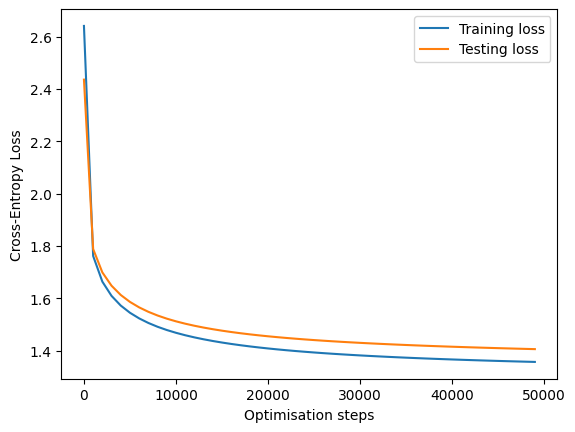

In [ ]:
plt.plot(range(0, n_steps, 1000), train_losses_numpy, label="Training loss")
plt.plot(range(0, n_steps, 1000), test_losses_numpy, label="Testing loss")
plt.legend()
plt.gca().set(xlabel="Optimisation steps", ylabel="Cross-Entropy Loss")
plt.show()

Interesting! We can see how our model **stopped improving** on the test dataset after about step 30,000, whereas it **continued improving** on the training dataset after this point. This phenomenon is sometimes called **overfitting**: the model is starting to **memorise the training data**, rather than learning useful patterns.

> **Important:** in the worst cases of overfitting, the model can start to **perform worse** on the held-out data. In this case, the testing loss starts to look like a **U shape**, rather than a decreasing curve.

#### Hyperparameter Optimisation 🔨

In the cell above, we used these **hyperparameters**:
- **Learning rate**: 0.001
- **Number of optimisation steps**: 50,000

Go back to this cell and try adjusting them up or down.
- What effects does this have on training?
- Does the model **learn better** when trained for longer, or with a smaller learning rate?
- Why might this be?

### Building the Network in `pytorch` 🔥

While `numpy` was fine for building a **very small** neural network, as our models get larger and larger it will quickly become difficult to manage. In reality, most machine learning researchers and engineers use a **dedicated library** to implement and train their models.

We're going to use the `pytorch` library, which is a very common library for building, training, and evaluating neural networks. Models in `pytorch` use Python `classes`. They inherit from the parent class `torch.nn.Module` and must define two methods: `__init__` and `forward`.

We'll also use the `CrossEntropyLoss` implementation in `pytorch`, so we don't need to define this ourselves. Finally, we'll replace our optimizer with `torch.optim.Adam`, which is typically used more often in machine learning than SGD.

> **Important**: note that the `CrossEntropyLoss` implementation in `pytorch` automatically performs the softmax operation on our logits. We don't need to do this ourselves.

In [ ]:
class SimpleInstrumentClassifier(torch.nn.Module):
    """
    A simple musical instrument classifier built in PyTorch.

    The model contains one linear layer to generate logits
    from an input feature vector.
    """

    def __init__(self, in_features: int, out_classes: int):
        """
        The __init__ method initialises the model.

        Inside it, we define the layers we want to use in the
        model, as well as the shape that they should take.

        Here, we define the number of input features that our
        linear layer should take in, and the number of output
        classes it should predict.
        """

        super().__init__()
        self.fc = torch.nn.Linear(in_features, out_classes)
        # Initialise the weights as with our numpy model
        torch.nn.init.normal_(self.fc.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.fc.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        The .forward method defines the "forward pass".

        It takes in the raw feature vector, passes it through
        all the layers of the model, and returns the output.
        """
        logits = self.fc(x)
        return logits


# Define hyperparameters
learning_rate = 0.001
n_steps = 50000

# Create the model, loss function, and Adam optimiser
torch_model = SimpleInstrumentClassifier(in_features=6, out_classes=14)
loss_fn = torch.nn.CrossEntropyLoss()    # includes softmax
optim = torch.optim.Adam(torch_model.parameters(), lr=learning_rate)

# Move everything onto the GPU if it is available
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_model.to(device)
loss_fn.to(device)

CrossEntropyLoss()

We can count how many parameters we have in our `pytorch` model and confirm that it is the same as the number in our `numpy` model:

In [ ]:
torch_parameters = sum(p.numel() for p in torch_model.parameters())

assert torch_parameters == numpy_parameters
print("Torch parameters: ", torch_parameters)
print("Numpy parameters: ", numpy_parameters)

Torch parameters:  98
Numpy parameters:  98


Now, we're ready to start training with our `pytorch` code. Let's adapt the training code we had from earlier:

In [ ]:
# TRAINING
print("STARTING TRAINING!")
train_losses_torch = []
test_losses_torch = []

# Convert all numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_idxs, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idxs, dtype=torch.long)

# Set our model to training mode
torch_model.train()

for n in range(n_steps):
    # Forward pass
    logits = torch_model(X_train_tensor)
    avg_loss = loss_fn(logits, y_train_tensor)

    # Backward pass
    optim.zero_grad()
    avg_loss.backward()
    optim.step()

    # Every 1000 steps, compute the test loss
    #  and print everything
    if n % 1000 == 0:
        # Forward pass with held-out data
        val_logits = torch_model(X_test_tensor)
        val_loss = loss_fn(val_logits, y_test_tensor)

        # No backward pass for held-out data

        test_losses_torch.append(val_loss.item())
        train_losses_torch.append(avg_loss.item())
        print(f"Training, step {n}/{n_steps}: train loss {round(avg_loss.item(), 3)}, test_loss {round(val_loss.item(), 3)}")


print("\n\n\n")
print("STARTING TESTING!")

# TESTING

# Set our model to evaluation mode
torch_model.eval()

# We use "no_grad" to not keep track of gradients
with torch.no_grad():
    logits = torch_model(X_test_tensor)
    loss = loss_fn(logits, y_test_tensor)
print(f"Test loss: {loss.item()}")

y_test_pred = torch.argmax(logits, axis=1).cpu().numpy()
acc = accuracy_score(y_test_idxs, y_test_pred)
print(f"Test accuracy: {acc}")

STARTING TRAINING!
Training, step 0/50000: train loss 2.635, test_loss 2.633
Training, step 1000/50000: train loss 2.237, test_loss 2.241
Training, step 2000/50000: train loss 2.114, test_loss 2.125
Training, step 3000/50000: train loss 2.025, test_loss 2.043
Training, step 4000/50000: train loss 1.951, test_loss 1.975
Training, step 5000/50000: train loss 1.888, test_loss 1.917
Training, step 6000/50000: train loss 1.832, test_loss 1.866
Training, step 7000/50000: train loss 1.784, test_loss 1.821
Training, step 8000/50000: train loss 1.741, test_loss 1.781
Training, step 9000/50000: train loss 1.703, test_loss 1.746
Training, step 10000/50000: train loss 1.669, test_loss 1.713
Training, step 11000/50000: train loss 1.638, test_loss 1.684
Training, step 12000/50000: train loss 1.611, test_loss 1.657
Training, step 13000/50000: train loss 1.587, test_loss 1.632
Training, step 14000/50000: train loss 1.565, test_loss 1.61
Training, step 15000/50000: train loss 1.545, test_loss 1.59
Trai

Great: after training our `pytorch` model, we get similar accuracy to our earlier `numpy` implementation. We might even see some improvements, as a result of replacing `SGD` with the more contemporary `Adam` optimizer.

We'll end this notebook by plotting our loss curves again:

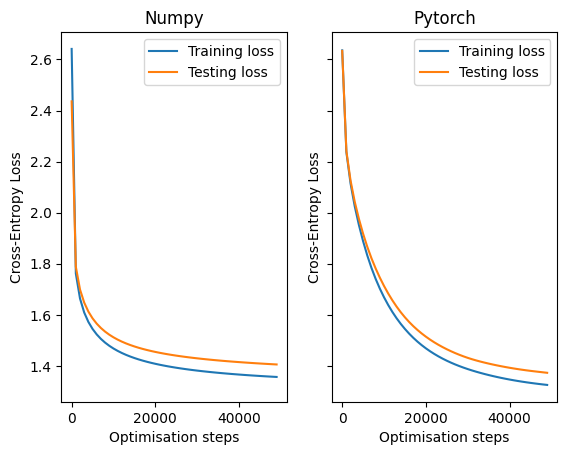

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

for (train, eval), label, ax_ in zip(
    [
        (train_losses_numpy, test_losses_numpy),
        (train_losses_torch, test_losses_torch)
    ],
    ["Numpy", "Pytorch"],
    ax.flatten()
):
    ax_.plot(range(0, n_steps, 1000), train, label=f"Training loss")
    ax_.plot(range(0, n_steps, 1000), eval, label=f"Testing loss")
    ax_.legend()
    ax_.set(xlabel="Optimisation steps", ylabel="Cross-Entropy Loss", title=label)

plt.show()

Cool. Notice how both models converge to a similar final loss value, regardless of which library we used for the implementation.

## Summary 🤖🎹

In this notebook, we explored different **learning paradigms** within machine learning. Our main goal was to train a computer to identify musical instruments (like a violin or a trumpet) just by listening to their sound. We used a special dataset called `TinySOL` which has many recordings of different instruments playing notes.

1.  **Feature Engineering:** Many machine learning models don't understand sound waves directly. So, we learned how to extract important characteristics (called **features**) from the audio, like the 'brightness' of a sound (spectral centroid) or how 'noisy' it is (zero-crossing rate).

2.  **Preprocessing:** Before feeding these features to our model, we had to 'clean them up' by a process called **normalisation**. This ensures all features are on a similar scale, making it easier for the model to learn efficiently.

3.  **Unsupervised Learning**: During unsupervised learning, a model learns to sort and cluster data, without explicit labels or groups. Our model used **k-Means clustering** to find natural clusters of instruments based on their sound features, even without knowing which instrument was which beforehand. We saw how it grouped instruments with similar sounds, like different types of string instruments.

4. **Supervised Learning:** This is like learning with a teacher. We gave the model examples of instrument sounds *along with their correct labels* (e.g., "this is a Cello"). We first used a simple model called **k-Nearest Neighbors (kNN)**, which predicts an instrument based on what its "closest neighbors" (most similar sounds) are. Then, we dove into **Neural Networks**, which are models inspired by how the human brain works. We built a small neural network that learns by adjusting its internal 'weights' and 'biases' to minimize errors in its predictions.

5.  **Checking Our Work:** After training, we tested how well our models performed on new sounds they had never heard before. We looked at **accuracy** (how many instruments it correctly identified) and **loss** (how much error it made).


## Going Deeper: Feature Learning with Neural Networks 🧠

You might have noticed that our neural networks **perform slightly worse** than our simpler, kNN model. This is not unusual, especially with such a small model (remember: our neural networks had **fewer than 100 parameters**!)

In general, we typically use neural networks to ***learn features from an input***, rather than extracting them first. In other words, we feed a neural network an **entire spectrogram**, extract features from this, then feed the **learned features** into the classification head. We can use a variety of different layers to extract features, such as a [convolutional layer](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

During training, then, ***the entire model updates***, including the parameters of the classification head ***and*** those of the feature extraction layers. This allows the model to learn to extract more powerful features from the input, and use them in the prediction. This stacking of multiple **feature extraction** and **classification** layers is what makes a neural network a **deep** neural network.

<img src="https://ivanderevianko.com/wp-content/uploads/2019/07/go-deeper.jpg" width="600px"/>
